In [1]:
import numpy as np
import quadtrees as qtrees
import simplebh as sbh

In [6]:
#BARNES HUT
#idea is simple: given particle system with interations,
#sum up the interactions on one particular particle

def SumTraverse(root,loc,m,interFun,farParameter=2):
    #root is QTree root
    #loc is location of particle
    #m is its mass
    #interFun is interactionFunction(m,m0,x,x0) between two particles
    #farParameter=2 means to approximate if dist/boxsize > 2
    #find all interactions
    
    if(len(root.children)>0):
        inter=0
        for child in root.children:
            
            if( np.linalg.norm(child.coord-loc,2)/child.boxsize >farParameter ):
                #if it can be approximated,then
                print('Approximate!!')
                inter=inter+interFun(m,child.mass,loc,child.coord)
            else:
                #if cannot be approximated
                inter=inter+SumTraverse(child,loc,m,interFun,farParameter)
                
        return inter
    else:
        if(np.linalg.norm(loc-root.coord,2)>1e-10):#if this is not the same particle
            return interFun(m,root.mass,loc,root.coord)
        else:
            return 0
        
        
def BHSummation(xs,ms,interFun,farParameter=2):
    # farParameter = 2  if distance is 2 times larger than box size, then approximate

    treeRoot = qtrees.TreeNode()
    treeRoot = qtrees.ConstructTree(xs,ms,treeRoot,level=0)
    
    inters = np.zeros([xs.shape[1]])
    for i in np.arange(xs.shape[1]):
        inters[i] = SumTraverse(treeRoot,xs[:,i],ms[i],interFun,farParameter)
    return inters

In [4]:
def GravInteraction(m0,m1,x0,x1):
    try:
        #kronecker shit
        x0k=np.kron(np.ones([1,x1.shape[1]]),x0)
        x1k=np.kron(x1,np.ones([1,x0.shape[1]]))
        res=m0*m1/np.reshape( np.linalg.norm(x1k-x0k,ord=2,axis=0), (x0.shape[1],x1.shape[1]))
        return res
    except:
        return m0*m1/np.linalg.norm(x1-x0,2,axis=0)

#GravInteraction(1,2,np.array([1,2]),np.array([2,2]))

In [2]:
xs = np.array([[10,15,-1,-0.8],[9,-5,-0.3,0.7]])*100
ms= np.array([1,2,1,2])

treeRoot = qtrees.TreeNode()#root
treeRoot=qtrees.ConstructTree(xs,ms,treeRoot,level=0)

construct root.coord= [-100.  -30.]
construct root.coord= [-80.  70.]
construct root.coord= [1500. -500.]
construct root.coord= [1000.  900.]


In [7]:
bhSum=BHSummation(xs,ms,GravInteraction,farParameter=2)

construct root.coord= [-100.  -30.]
construct root.coord= [-80.  70.]
construct root.coord= [1500. -500.]
construct root.coord= [1000.  900.]
Approximate!!
Approximate!!
Approximate!!
Approximate!!


In [8]:
F= GravInteraction(ms[:,np.newaxis],ms[np.newaxis,:], xs, xs)
F[np.diag(np.ones([4])).astype('bool')]=0
print(F)
justSum=F @ np.ones([4])

[[0.         0.00134535 0.00069423 0.00146833]
 [0.00134535 0.         0.00119933 0.00238142]
 [0.00069423 0.00119933 0.         0.01961161]
 [0.00146833 0.00238142 0.01961161 0.        ]]


d:\programs\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [9]:
np.linalg.norm(bhSum-justSum,2)

0.0

In [11]:
sbh.BHSummation(xs,ms,GravInteraction,farParameter=2)-justSum # WORKS!!!

construct root.coord= [-100.  -30.]
construct root.coord= [-80.  70.]
construct root.coord= [1500. -500.]
construct root.coord= [1000.  900.]


array([0., 0., 0., 0.])

## Complexity Study of Simple BH

For each $N$ generate $N$ particles in 2D from some gaussian mixture, perform several tests, check errors and the stuff.

In [2]:
import simplebh as sbh
import numpy as np
import quadtrees as qtrees
import sklearn.datasets.samples_generator as skdat
import matplotlib.pyplot as plt
%matplotlib inline
# to not run previous sections

import mybootstrap as boots
import time as pytime
import tqdm

#JUPYTER NOTEBOOK THEMES\n",
# delete this if native theme is ok\n",
from jupyterthemes import jtplot
# choose which theme to inherit plotting style from\n",
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd\n",
jtplot.style(theme='oceans16')
# set \"context\" (paper, notebook, talk, poster)\n",
# scale font-size of ticklabels, legend, etc.\n",
# remove spines from x and y axes and make grid dashed\n",
jtplot.style(context='talk', fscale=1.4, spines=True, gridlines='--')

def GravInteraction(m0,m1,x0,x1):
    try:
        #kronecker shit
        x0k=np.kron(np.ones([1,x1.shape[1]]),x0)
        x1k=np.kron(x1,np.ones([1,x0.shape[1]]))
        res=m0*m1/np.reshape( np.linalg.norm(x1k-x0k,ord=2,axis=0), (x0.shape[1],x1.shape[1]))
        return res
    except:
        return m0*m1/np.linalg.norm(x1-x0,2,axis=0)

In [3]:
N0=10
N1=100
Ns = np.arange(N0,N1+10,10)

NExp=50 # enough?

timesBH=np.zeros([NExp,Ns.shape[0]])
timesDirect=np.zeros([NExp,Ns.shape[0]])

def GenerateInstance(N,maxClusters=5,minMass=2,maxMass=20):
    #Generates N particles in plane
    #first sets up a number of clusters
    #then generates centers
    #finally, generates something similar to GaussianMixture
    
    clustNumber = np.random.randint(1,maxClusters+1)
    centers = np.random.randn(clustNumber,2)*1000
    # Generate sample data
    X, _ = skdat.make_blobs(n_samples=N, centers=centers, cluster_std=50)
    X=X.T
    masses=np.random.uniform(minMass,maxMass,size=N)
    return X,masses

    
for i in tqdm.tqdm(np.arange(Ns.shape[0])):
    for expId in np.arange(NExp):
        xs,ms = GenerateInstance(Ns[i])
        
        #BH summation
        time0=pytime.time()
        bhSum = sbh.BHSummation(xs,ms,GravInteraction,farParameter=3)    
        timesBH[expId,i]=pytime.time()-time0
        
        #DirectSummation
        time0=pytime.time()
        F= GravInteraction(ms[:,np.newaxis],ms[np.newaxis,:], xs, xs)
        F[np.diag(np.ones([Ns[i]])).astype('bool')]=0 # avoid Infinities on the diagonal
        justSum=F @ np.ones([Ns[i]])
        timesDirect[expId,i]=pytime.time()-time0
        #print(np.linalg.norm(bhSum-justSum,2))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]


In [4]:
timesDirectCI = np.array([ boots.BootstrapTTableCIMean(timesDirect[:,i],NSamples=5000) \
                 for i in np.arange(timesDirect.shape[1])])
timesBHCI = np.array([ boots.BootstrapTTableCIMean(timesBH[:,i],NSamples=5000) \
                 for i in np.arange(timesBH.shape[1])])

C:\Users\XuMuKPad\Documents\Skoltech\fastpdeHW\git\ps1\mybootstrap.py:26: RuntimeWarning: divide by zero encountered in true_divide
  ts = (np.mean(resampled,axis=0)-m0)/np.std(resampled,axis=0)


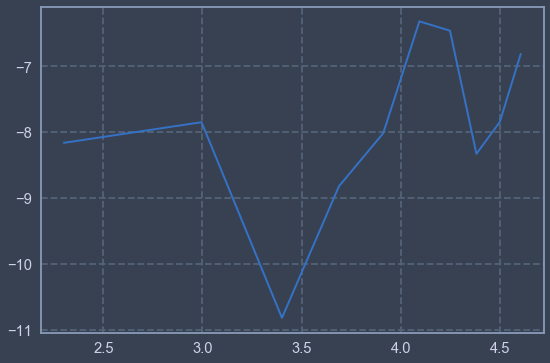

In [7]:
#just draw something
f,ax =plt.subplots( figsize=(9,6))

ax.plot(np.log(Ns),np.log(np.mean(timesDirect,axis=0)))
ax.plot(np.log(Ns),np.log(np.mean(timesBH,axis=0)))
#ax.errorbar(Ns,np.mean(timesDirect,axis=0),yerr=timesDirectCI.T)
#ax.errorbar(Ns,np.mean(timesBH,axis=0),yerr=timesBHCI.T)

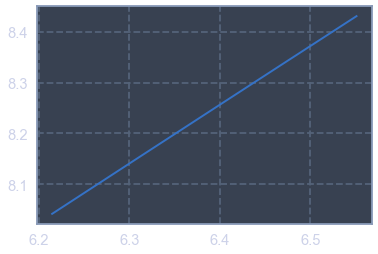

In [28]:
ys=Ns*np.log(Ns)

f,ax = plt.subplots()

ax.plot(np.log(Ns),np.log(ys))